# Refreshing my memory and trying some methods for Uptake assessment 

In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from src.data import load_data
from src.visualization import plot_continuous_var, plot_categorical_var, plot_var_timeseries
from src.visualization import plot_learning_curve, plot_feature_importances
from src.utils import pipeline_cv_score

# # Machine Learning 
import sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, TimeSeriesSplit 
from sklearn.model_selection import cross_val_score, learning_curve, GridSearchCV
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier

# Interpretation of model results
from pdpbox import pdp, get_dataset, info_plots
import shap

In [3]:
df = load_data()

In [51]:
df0 = df.copy()

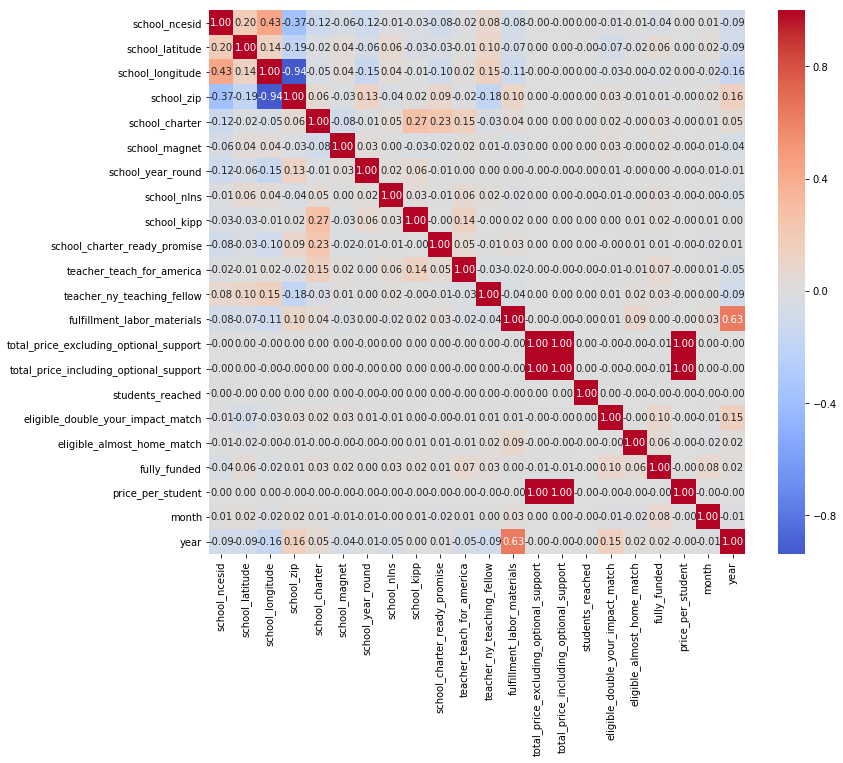

In [4]:
cols = df.select_dtypes(exclude='O').columns
corr = df[cols].corr()
plt.figure(figsize=[12,10])
g = sns.heatmap(corr,annot=True, fmt = ".2f", cmap = "coolwarm", center=0)

In [14]:
cols_to_keep = [
    'school_metro', 'school_charter', 'school_magnet', 
    'school_year_round', 'school_nlns', 'school_kipp',
    'school_charter_ready_promise', 'teacher_prefix',
    'teacher_teach_for_america', 'teacher_ny_teaching_fellow',
    'primary_focus_area', 'resource_type',
   'poverty_level', 'grade_level', 'fulfillment_labor_materials',
   'total_price_excluding_optional_support', 'students_reached',
   'eligible_double_your_impact_match', 'eligible_almost_home_match',
   'price_per_student', 'month', 'year',
    'state_mapped', 'city_mapped', 'primary_focus_subject_mapped'
]

cols_to_drop = [
    'projectid',  # unique identifier
    'title', 'short_description', 'need_statement', 'essay',  # could do NLP later
    'teacher_acctid', 'schoolid', 'school_ncesid', 'school_district', 'school_county', 'school_zip' # could try using these identifiers later
    'date', 'date_posted',  # has already had month and year extracted
    'secondary_focus_subject', 'secondary_focus_area'  # high dimensionality, try later
    'school_state', 'school_city', 'primary_focus_subject' # were mapped to lower dimensionality features
    'total_price_including_optional_support', # correlated with other price feature, could do PCA or feature selection 
    'school_latitude', 'school_longitude',  # need a better way to handle location
]

# Make sure I didn't forget any columns
assert all([col in cols_to_keep + cols_to_drop] for col in df.columns)

In [17]:
from src.data import OUTCOME as outcome

df_test = df.query('year == 2013')
df_train = df.query('year < 2013')
X = df_train[cols_to_keep]
y = df_train[outcome]
X_test = df_test[cols_to_keep]
y_test = df_test[outcome]

# TEMP - subset for faster model development
X = X[:100_000]
y = y[:100_000]

# Use a time series split
tscv = TimeSeriesSplit(n_splits=5)

In [20]:
num_cols = X.select_dtypes(['integer', 'float']).columns.tolist()
num_si_step = ('si', SimpleImputer(strategy='median'))
num_ss_step = ('ss', StandardScaler())
num_steps = [num_si_step] #num_ss_step - for now we won't use scaling, as it shouldn't matter for tree-based algorithms 
num_pipe = Pipeline(num_steps)
num_transformers = [('num', num_pipe, num_cols)]

cat_cols = X.select_dtypes('O').columns.tolist()
cat_si_step = ('si', SimpleImputer(strategy='constant',
                   fill_value='MISSING'))
# cat_si_step = ('si', SimpleImputer(strategy='most_frequent'))  # seems way slower
cat_ohe_step = ('ohe', OneHotEncoder(sparse=False,
                    handle_unknown='ignore'))
cat_steps = [cat_si_step, cat_ohe_step]
cat_pipe = Pipeline(cat_steps)
cat_transformers = [('cat', cat_pipe, cat_cols)]

transformers = [('cat', cat_pipe, cat_cols),
                    ('num', num_pipe, num_cols)]
ct = ColumnTransformer(transformers=transformers)

# Parameters not tuned
classifier = RandomForestClassifier(max_depth=12, n_estimators=20, random_state=42) 
pipeline = Pipeline([('transformer', ct),
                     ('classifier', classifier)])


In [21]:
%%time
pipeline_cv_score(pipeline, X, y, tscv)

Cross Validation Score = 0.718 with std = 0.0017
Wall time: 10.7 s


# Add the `schoolid` as 
- also try with mapping rare occurences (n < 5) to "other"

In [41]:
df['school_count'] = df.groupby('schoolid')['schoolid'].transform('count')

In [52]:
df.loc[df.school_count < 10, 'schoolid'] = 'RARE'

In [56]:
df['school_count'] = df.groupby('schoolid')['schoolid'].transform('count')

In [67]:
df['school_success'] = df.groupby('schoolid')[outcome].transform('mean')

In [170]:
df['weight'] = df['school_count'].transform(lambda x: regularization_decay(x))
GLOBAL_MEAN = df[outcome].mean()
df['school_success_weighted'] = df['school_success'] * df['weight'] + (1-df['weight']) * GLOBAL_MEAN

In [57]:
success = df.query('school_count > 10').groupby('schoolid')[outcome].mean()

(array([  38.,   63.,  175.,  438.,  869., 2000., 2740., 3129., 2689.,
        1250.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

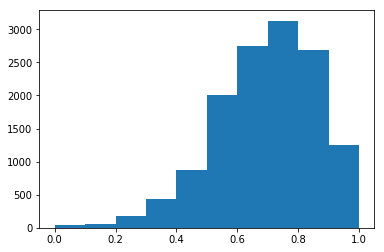

In [58]:
plt.hist(success)

In [264]:
def regularization_decay(frequency, k=20, f=10):
    return 1 / (1 + np.exp(-1*(frequency-k)/f))

In [265]:
freqs = list(range(0,100,5))
freqs

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]

[<matplotlib.lines.Line2D at 0x17d037f8d30>]

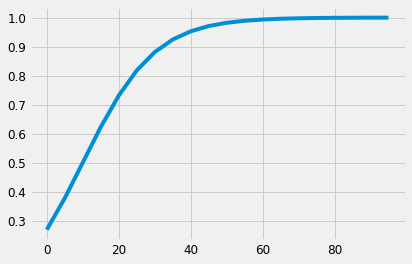

In [269]:
weights = [regularization_decay(f, k=10) for f in freqs]
plt.plot(freqs, weights)

In [60]:
df.query('schoolid == "RARE"')[outcome].mean()

0.5968327154038724

In [61]:
df[outcome].mean()

0.6954059735906453

In [63]:
success = df.query('schoolid != "RARE"').groupby('schoolid')[outcome].agg(['mean', 'count'])

In [163]:
success['weight'] = success['count'].transform(lambda x: regularization_decay(x))

In [167]:
GLOBAL_MEAN = df[outcome].mean()
success['mean_weighted'] = success['mean'] * success['weight'] + (1-success['weight']) * GLOBAL_MEAN

In [168]:
success.head()

,mean,count,success_weight,weight,mean_weighted
schoolid,,,,,
00014d8717dd762910c815aceb2e5521,1.000000,21,0.524979,0.524979,0.855311
00079011fea3d16aa2d3a4025aae6db6,0.727273,11,0.289050,0.289050,0.704617
000bf85683f6aa7bb3e150dbc6c7748d,0.600000,35,0.817574,0.817574,0.617404
000d35d459d2ac0dc6c91ae875954458,0.181818,33,0.785835,0.785835,0.291811
000f353c81b212708ffe580108729ff5,0.363636,11,0.289050,0.289050,0.599508


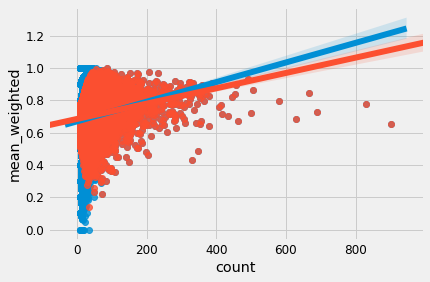

In [169]:
sns.regplot('count', 'mean', data=success)
sns.regplot('count', 'mean_weighted', data=success)

In [171]:
cols_to_keep = [
    'school_metro', 'school_charter', 'school_magnet', 
    'school_year_round', 'school_nlns', 'school_kipp',
    'school_charter_ready_promise', 'teacher_prefix',
    'teacher_teach_for_america', 'teacher_ny_teaching_fellow',
    'primary_focus_area', 'resource_type',
   'poverty_level', 'grade_level', 'fulfillment_labor_materials',
   'total_price_excluding_optional_support', 'students_reached',
   'eligible_double_your_impact_match', 'eligible_almost_home_match',
   'price_per_student', 'month', 'year',
    'state_mapped', 'city_mapped', 'primary_focus_subject_mapped',
    'school_success', 'school_success_weighted'
]

cols_to_drop = [
    'projectid',  # unique identifier
    'title', 'short_description', 'need_statement', 'essay',  # could do NLP later
    'teacher_acctid', 'schoolid', 'school_ncesid', 'school_district', 'school_county', 'school_zip' # could try using these identifiers later
    'date', 'date_posted',  # has already had month and year extracted
    'secondary_focus_subject', 'secondary_focus_area'  # high dimensionality, try later
    'school_state', 'school_city', 'primary_focus_subject' # were mapped to lower dimensionality features
    'total_price_including_optional_support', # correlated with other price feature, could do PCA or feature selection 
    'school_latitude', 'school_longitude',  # need a better way to handle location
]

# Make sure I didn't forget any columns
assert all([col in cols_to_keep + cols_to_drop] for col in df.columns)

In [185]:
from src.data import OUTCOME as outcome

df_test = df.query('year == 2013')
df_train = df.query('year < 2013')
X = df_train[cols_to_keep]
y = df_train[outcome]
X_test = df_test[cols_to_keep]
y_test = df_test[outcome]

# TEMP - subset for faster model development
# X = X[:100_000]
# y = y[:100_000]

# Use a time series split
tscv = TimeSeriesSplit(n_splits=5)

In [173]:
num_cols = X.select_dtypes(['integer', 'float']).columns.tolist()
num_si_step = ('si', SimpleImputer(strategy='median'))
num_ss_step = ('ss', StandardScaler())
num_steps = [num_si_step] #num_ss_step - for now we won't use scaling, as it shouldn't matter for tree-based algorithms 
num_pipe = Pipeline(num_steps)
num_transformers = [('num', num_pipe, num_cols)]

cat_cols = X.select_dtypes('O').columns.tolist()
cat_si_step = ('si', SimpleImputer(strategy='constant',
                   fill_value='MISSING'))
# cat_si_step = ('si', SimpleImputer(strategy='most_frequent'))  # seems way slower
cat_ohe_step = ('ohe', OneHotEncoder(sparse=False,
                    handle_unknown='ignore'))
cat_steps = [cat_si_step, cat_ohe_step]
cat_pipe = Pipeline(cat_steps)
cat_transformers = [('cat', cat_pipe, cat_cols)]

transformers = [('cat', cat_pipe, cat_cols),
                    ('num', num_pipe, num_cols)]
ct = ColumnTransformer(transformers=transformers)

# Parameters not tuned
classifier = RandomForestClassifier(max_depth=12, n_estimators=20, random_state=42) 
pipeline = Pipeline([('transformer', ct),
                     ('classifier', classifier)])


In [174]:
%%time
pipeline_cv_score(pipeline, X, y, tscv)

Cross Validation Score = 0.7395 with std = 0.0018
Wall time: 16.5 s


Wall time: 55.6 s


<module 'matplotlib.pyplot' from 'c:\\users\\zrankin\\appdata\\local\\continuum\\miniconda3\\envs\\kaggle\\lib\\site-packages\\matplotlib\\pyplot.py'>

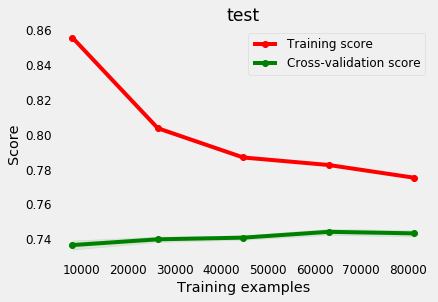

In [187]:
%%time
plot_learning_curve(pipeline, 'test', X, y, cv=tscv)

In [176]:
def rename_features(feature_list, old, new):
    return [f.replace(old, new) for f in feature_list]
    
def rename_ohe_features(ohe_feature_list, column_names):
    """
    Utility function to add original feature names after sklearn OneHotEncoder
    e.g. if 'myfeature' is encoded, it gives ['x0_cat1', 'x0_cat2']
    rename_ohe_features(['x0_cat1', 'x0_cat2'], 'myfeature') 
    returns ['myfeature_cat1', 'myfeature_cat2']
    """
    for i, col in enumerate(column_names):
        ohe_feature_list = rename_features(ohe_feature_list, f'x{i}', col)
    return ohe_feature_list


In [177]:
X_transformed = ct.fit_transform(X)

# Get the feature names from pipeline
ohe_feature_list = list(ct.named_transformers_['cat'].named_steps['ohe'].get_feature_names())
cat_features = rename_ohe_features(ohe_feature_list, cat_cols)
cat_features

# Get a pd.DataFrame with the feature names 
df_transformed = pd.DataFrame(X_transformed, columns=cat_features + num_cols)
df_transformed.shape

df_transformed.head()

,school_metro_MISSING,school_metro_rural,school_metro_suburban,school_metro_urban,teacher_prefix_Dr.,teacher_prefix_Mr.,teacher_prefix_Mrs.,teacher_prefix_Ms.,primary_focus_area_Applied Learning,primary_focus_area_Health & Sports,...,fulfillment_labor_materials,total_price_excluding_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,price_per_student,month,year,school_success,school_success_weighted
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,9.0,703.34,90.0,0.0,0.0,9.530333,10.0,2009.0,0.551724,0.593255
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,35.0,207.43,8.0,0.0,0.0,30.505000,6.0,2011.0,0.596833,0.596833
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,35.0,440.01,25.0,1.0,0.0,20.706400,9.0,2010.0,0.725689,0.725689
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,17.0,798.85,20.0,0.0,0.0,48.710500,4.0,2009.0,0.596833,0.596833
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,30.0,797.30,11.0,0.0,0.0,85.272727,12.0,2012.0,0.705882,0.705431


In [178]:
classifier.fit(df_transformed, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

<Figure size 576x1080 with 0 Axes>

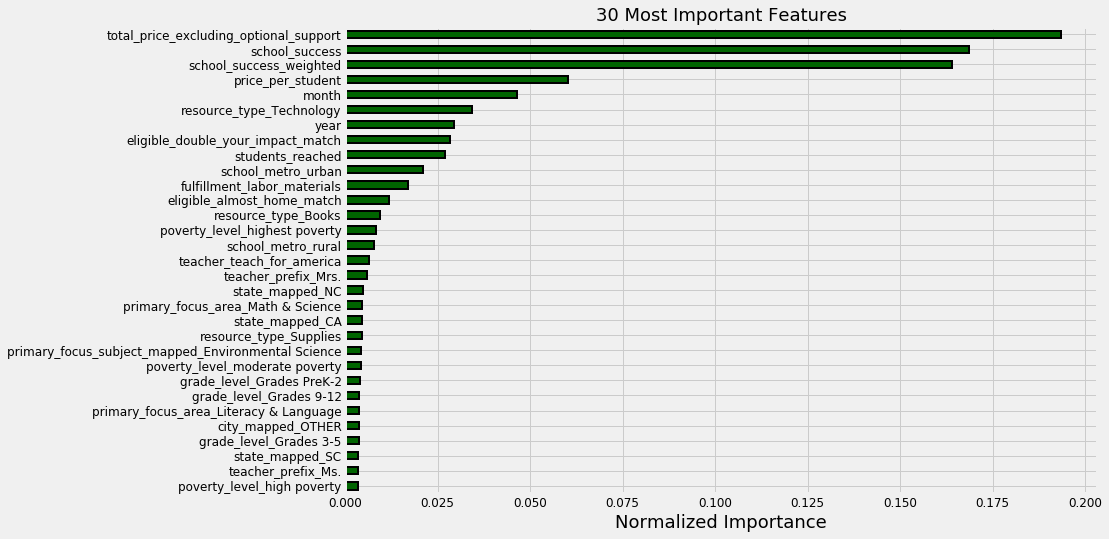

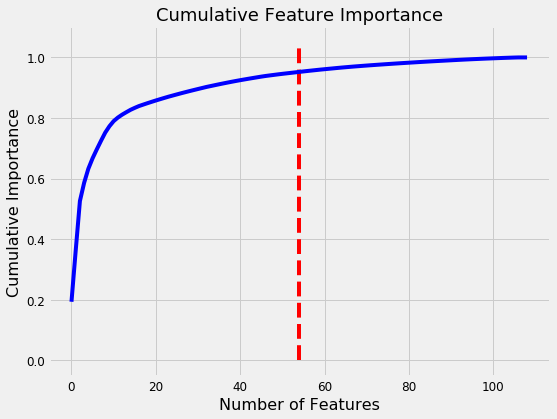

54 features required for 95% of cumulative importance.


In [179]:
# Feature importances
features = df_transformed.columns
feature_importances = pd.DataFrame({'feature': features, 'importance': classifier.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)

plot_feature_importances(feature_importances, n=30, threshold=0.95)

In [180]:
row_to_show = 1
data_for_prediction = df_transformed.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
# Create object that can calculate shap values
explainer = shap.TreeExplainer(classifier)
# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

classifier.predict(data_for_prediction_array)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

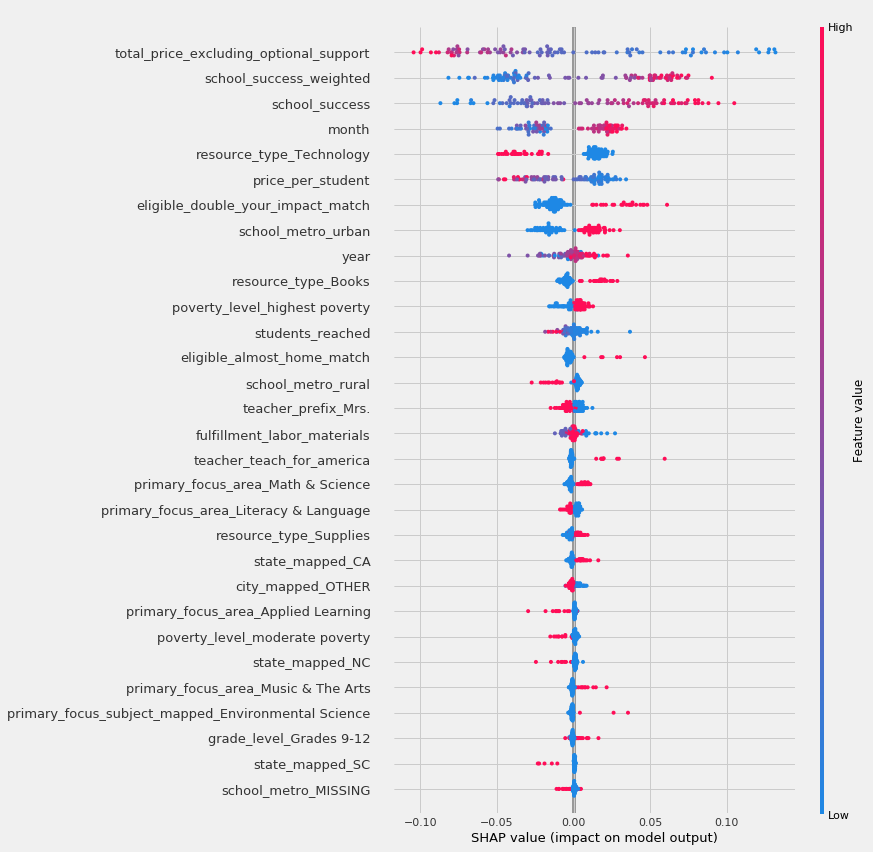

In [181]:
df_subset = df_transformed.sample(100, random_state=42)
shap_values = explainer.shap_values(df_subset)
shap.summary_plot(shap_values[1], df_subset, max_display=30)

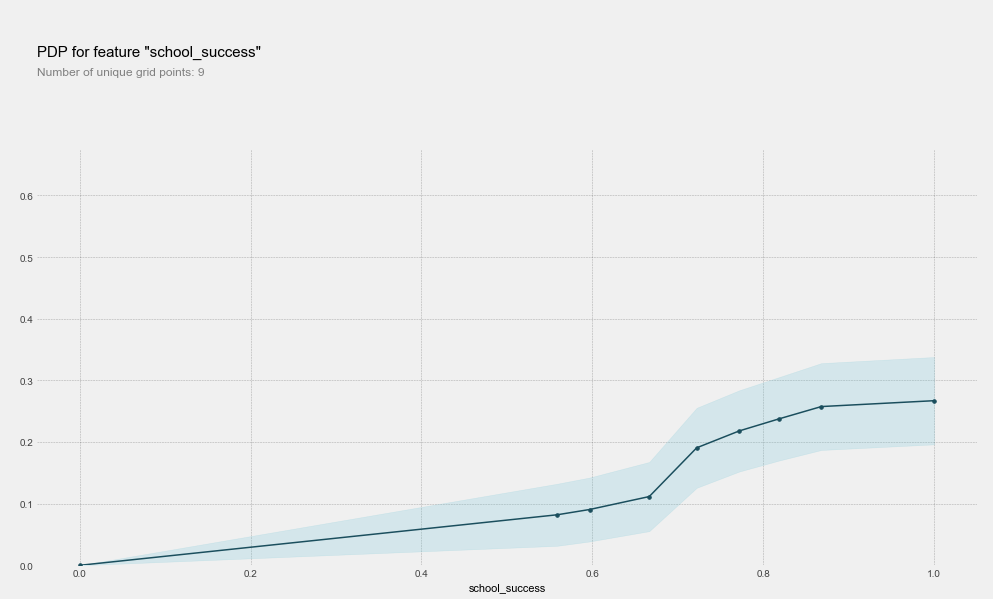

In [122]:
pdp_feature = pdp.pdp_isolate(model=classifier, dataset=df_transformed, model_features=df_transformed.columns.tolist(), feature='school_success')
pdp.pdp_plot(pdp_feature, 'school_success')
plt.show()

In [182]:
enc = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [183]:
enc.fit(df[cat_cols])

ValueError: Input contains NaN

In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 619326 entries, 0 to 619325
Data columns (total 51 columns):
projectid                                 619326 non-null object
title                                     619309 non-null object
short_description                         619194 non-null object
need_statement                            617854 non-null object
essay                                     619323 non-null object
teacher_acctid                            619326 non-null object
schoolid                                  619326 non-null object
school_ncesid                             580478 non-null float64
school_latitude                           619326 non-null float64
school_longitude                          619326 non-null float64
school_city                               619326 non-null object
school_state                              619326 non-null object
school_zip                                619322 non-null float64
school_metro                            

In [193]:
from sklearn.linear_model import SGDClassifier

In [194]:
num_cols = X.select_dtypes(['integer', 'float']).columns.tolist()
num_si_step = ('si', SimpleImputer(strategy='median'))
num_ss_step = ('ss', StandardScaler())
num_steps = [num_si_step] #num_ss_step - for now we won't use scaling, as it shouldn't matter for tree-based algorithms 
num_pipe = Pipeline(num_steps)
num_transformers = [('num', num_pipe, num_cols)]

cat_cols = X.select_dtypes('O').columns.tolist()
cat_si_step = ('si', SimpleImputer(strategy='constant',
                   fill_value='MISSING'))
# cat_si_step = ('si', SimpleImputer(strategy='most_frequent'))  # seems way slower
cat_ohe_step = ('ohe', OneHotEncoder(sparse=False,
                    handle_unknown='ignore'))
cat_steps = [cat_si_step, cat_ohe_step]
cat_pipe = Pipeline(cat_steps)
cat_transformers = [('cat', cat_pipe, cat_cols)]

transformers = [('cat', cat_pipe, cat_cols),
                    ('num', num_pipe, num_cols)]
ct = ColumnTransformer(transformers=transformers)

# Parameters not tuned
classifier = SGDClassifier(loss="log", penalty="elasticnet", random_state=42)
pipeline = Pipeline([('transformer', ct),
                     ('classifier', classifier)])


In [334]:
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin

def regularization_decay(frequency, k=20, f=10):
    "https://www.slideshare.net/0xdata/feature-engineering-83511751"
    return 1 / (1 + np.exp(-1*(frequency-k)/f))

class TargetMeanEncoder(BaseEstimator, TransformerMixin):
    """
    PRELIMINARY WAY OF DEALING WITH HIGH DIMENSIONALITY FEATURES
    """
    def __init__(self, weighted=True):
        self.weighted = weighted

    def fit(self, X, y, id_var):
        self.id_var = id_var
        df = pd.DataFrame({f'{id_var}':X[id_var], 'target':y})
        self.data = df.groupby(id_var).agg(['mean', 'count']).reset_index()
        self.data.columns = [id_var, f'{id_var}_mean', f'{id_var}_count']
        
        if self.weighted: 
            k = self.data[f'{id_var}_count'].median()
            self.weights = regularization_decay(self.data[f'{id_var}_count'])
        else: 
            self.weights = 1 
        
        self.global_mean = y.mean()
        self.data[f'{id_var}_mean'] = self.weights * self.data[f'{id_var}_mean'] + (1 - self.weights) * self.global_mean

    def transform(self, X):
        # TODO - how to account for ones without merge - fill missing with global mean? What about counts? 
        df = pd.merge(X, self.data, how='outer')
        fill_vals = {f'{self.id_var}_mean': self.global_mean, f'{self.id_var}_count': 0}
        df = df[[f'{self.id_var}_mean', f'{self.id_var}_count']].fillna(fill_vals)
        return df
        

In [308]:
testing[['schoolid_mean', 'schoolid_count']].fillna?

Object `fillna` not found.


In [312]:
fill_vals = {'schoolid_mean':-1, 'schoolid_count':-1}

In [315]:
testing[['schoolid_mean', 'schoolid_count']].fillna(fill_vals, inplace=True)

In [287]:
pd.merge?

In [335]:
enc = TargetMeanEncoder(weighted=False)

In [336]:
enc.fit(df_train, df_train[outcome], 'schoolid')

In [332]:
enc.data.head()

,schoolid,schoolid_mean,schoolid_count
0,00014d8717dd762910c815aceb2e5521,1.000000,18
1,00079011fea3d16aa2d3a4025aae6db6,0.857143,7
2,000bf85683f6aa7bb3e150dbc6c7748d,0.566667,30
3,000d35d459d2ac0dc6c91ae875954458,0.095238,21
4,000f353c81b212708ffe580108729ff5,0.363636,11


In [337]:
testing = enc.transform(df_test)

In [338]:
testing.schoolid_mean.describe()

count    133877.000000
mean          0.674885
std           0.180789
min           0.000000
25%           0.578078
50%           0.666667
75%           0.800000
max           1.000000
Name: schoolid_mean, dtype: float64

In [316]:
testing.loc[testing.schoolid_mean.isna()]

,projectid,title,short_description,need_statement,essay,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,...,year,state_mapped,city_mapped,primary_focus_subject_mapped,school_count,school_success,weight,school_success_weighted,schoolid_mean,schoolid_count
34612,fffa75021cdd838e658b331847c78ad2,Stepping Stones,"Teaching Mathematics has really changed, and t...",My students need Stepping Stones Math Kit for ...,"Teaching Mathematics has really changed, and t...",bd202f86ad86ba83875f754e7ff89964,6b1ea7aa5d39c00b9a260f60d9a35e86,1.602100e+11,43.648253,-116.347880,...,2013.0,OTHER,OTHER,Mathematics,21.0,1.000000,0.524979,0.855311,NaN,NaN
34613,eb474a7d60c9ce8df634ab5cbe9a42a4,Stepping Stones Math,Kids love hands-on activities and interactive ...,My students need Stepping Stones math Kit and ...,Kids love hands-on activities and interactive ...,fd5ecf4f2ef8389a2b072a765da6c806,6b1ea7aa5d39c00b9a260f60d9a35e86,1.602100e+11,43.648253,-116.347880,...,2013.0,OTHER,OTHER,Mathematics,21.0,1.000000,0.524979,0.855311,NaN,NaN
34614,db6b114a9932d2d4a7cb74f890555383,Dreaming of Math,Did you enjoy math as a child? Was it somethin...,My students need an individualized way to lear...,Did you enjoy math as a child? Was it somethi...,05034615c9f7ba53fe4f1c2ef4d68fa9,6b1ea7aa5d39c00b9a260f60d9a35e86,1.602100e+11,43.648253,-116.347880,...,2013.0,OTHER,OTHER,Mathematics,21.0,1.000000,0.524979,0.855311,NaN,NaN
34615,cdded1c94339516e3f2525d251e54223,Reading Through the Big Universe,"Were you a ""Blue Bird""; or were you fortunate ...",My students need the Big Universe digital cour...,"Were you a ""Blue Bird""; or were you fortunate ...",61b3dbca137e6dcc235fd9c3fb394a4b,6b1ea7aa5d39c00b9a260f60d9a35e86,1.602100e+11,43.648253,-116.347880,...,2013.0,OTHER,OTHER,Literacy,21.0,1.000000,0.524979,0.855311,NaN,NaN
34616,9b13029874447fb2cc3d7f0c45a022b0,Mathematicians In Training,My goal is to prepare students to be live-long...,My students need a Dream Box a digital way to...,My goal is to prepare students to be live-long...,7daeaec9d17022c5f007ea0761876d1c,6b1ea7aa5d39c00b9a260f60d9a35e86,1.602100e+11,43.648253,-116.347880,...,2013.0,OTHER,OTHER,Mathematics,21.0,1.000000,0.524979,0.855311,NaN,NaN
34617,81a412ffd28b9abc44687e41702a74aa,Daring to DreamBox,In the past many students have thought of math...,My students need digital courseware that will ...,In the past many students have thought of math...,e18e8e6e94dd9d9f963336001556cf37,6b1ea7aa5d39c00b9a260f60d9a35e86,1.602100e+11,43.648253,-116.347880,...,2013.0,OTHER,OTHER,Mathematics,21.0,1.000000,0.524979,0.855311,NaN,NaN
34618,7abbf9e120e8c535219ea31be65a51fa,Creating Life-Long Learners,Remember the days where students were handed w...,My students need BrainPop for access to a fun ...,Remember the days where students were handed w...,7daeaec9d17022c5f007ea0761876d1c,6b1ea7aa5d39c00b9a260f60d9a35e86,1.602100e+11,43.648253,-116.347880,...,2013.0,OTHER,OTHER,Mathematics,21.0,1.000000,0.524979,0.855311,NaN,NaN
34619,7a8af9c3165bdf0006b1d424af80ddc4,"Mathematical ""Dreaming",Remember the days of boring math worksheets an...,My students need a digital courseware site tha...,Remember the days of boring math worksheets an...,8ba4aae3655f80e71deeee8f28b183d6,6b1ea7aa5d39c00b9a260f60d9a35e86,1.602100e+11,43.648253,-116.347880,...,2013.0,OTHER,OTHER,Mathematics,21.0,1.000000,0.524979,0.855311,NaN,NaN
34620,6bb11763be02462740bad180b16c6abc,Let's Go Lexia!,Reading instruction has definitely evolved ove...,My students need a digital courseware program ...,Reading education continues to change and deve...,8ba4aae3655f80e71deeee8f28b183d6,6b1ea7aa5d39c00b9a260f60d9a35e86,1.602100e+11,43.648253,-116.347880,...,2013.0,OTHER,OTHER,Literacy,21.0,1.000000,0.524979,0.855311,NaN,NaN
34621,654fd4975e7554bff782fce551345e0d,Stepping Stones Math Project,My classroom is in need of additional math sup...,My students need Stepping Stones Math Program ...,My classroom is in need of additional math sup...,b401881c002c

In [211]:
testing = pd.DataFrame({'col1':df['schoolid'], 'col2':y})

In [212]:
testing.head()

,col1,col2
0,301c9bf0a45d159d162b65a93fddd74e,0.0
1,RARE,1.0
2,9943fdb43ab5f2b53f27e961caf9e90a,1.0
3,RARE,0.0
4,RARE,NaN


In [209]:
 pd.DataFrame?

In [200]:
from category_encoders.leave_one_out import LeaveOneOutEncoder

In [202]:
enc = LeaveOneOutEncoder()

In [207]:
enc_success = enc.fit_transform(df[['schoolid']], df[outcome])

KeyboardInterrupt: 

In [205]:
enc_success = enc.fit_transform(df[['teacher_acctid', 'schoolid']], df[outcome])

KeyboardInterrupt: 

In [ ]:
enc_success.head()

In [ ]:
df['school_success'].head()